# Patient Similarity Graph Using GNN (SAGEConv)


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import os
import os.path as osp

import torch
import torch_geometric
# from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


os.environ['TORCH'] = torch.__version__
print(torch.__version__)
use_cuda_if_available = False

1.13.1


In [95]:
def dropping_cols(df, p=80):
    #1- count the number of NaN values in each column
    #2- calculate the percentage of NaN values in each column
    #3- get the list of columns to drop
    #4- drop the columns with more than 80% NaN values
    nan_counts = df.isna().sum()    
    nan_percentages = nan_counts / len(df) * 100 
    cols_to_drop = nan_percentages[nan_percentages > p].index.tolist()
    df = df.drop(cols_to_drop, axis=1)
    return df   

In [96]:
def split_mask(n, tr=0.8, vl=0.1, ts=0.1):
    import random
    train_size = int(n * tr)
    val_size = int(n * vl)
    test_size = int(n * ts)

    # Initialize the three lists
    train_list = torch.zeros(n, dtype=torch.bool)
    val_list   = torch.zeros(n, dtype=torch.bool)
    test_list  = torch.zeros(n, dtype=torch.bool)

    indices = [i for i in range(n)]
    random.shuffle(indices)

    for i in range(n):
        j = indices[i]
        if i <train_size:
            train_list[j] = torch.tensor(True)
        elif i>= train_size and i< train_size + val_size:
            val_list[j] = torch.tensor(True)
        elif i>=train_size + val_size:
            test_list[j] = torch.tensor(True)
    return train_list, val_list, test_list


# Reading Lung dataset

In [97]:
ndf = pd.read_csv('data/Lung/SM/numericalSM.csv')
cdf = pd.read_csv('data/Lung/SM/categoricalSM.csv')
original_lung = pd.read_csv(f'data/raw/numerical.csv', index_col=0)
ndf = ndf.loc[:, ~ndf.columns.str.contains('^Unnamed')]
ndf

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,768,769,770,771,772
0,1.000000,0.090335,0.060756,0.066758,0.020480,0.025235,0.023735,0.021992,0.018617,0.022272,...,0.042391,0.037341,0.046716,0.061183,0.027825,0.023787,0.042997,0.040514,0.040044,0.022366
1,0.090335,1.000000,0.086969,0.058750,0.020027,0.024279,0.022181,0.020940,0.019407,0.021587,...,0.035784,0.031703,0.042610,0.047615,0.024892,0.024673,0.040040,0.036020,0.038621,0.022353
2,0.060756,0.086969,1.000000,0.046873,0.020022,0.020304,0.020201,0.019231,0.021851,0.021909,...,0.027387,0.026645,0.038336,0.040296,0.022389,0.026778,0.041972,0.032968,0.047868,0.021560
3,0.066758,0.058750,0.046873,1.000000,0.019342,0.026898,0.024809,0.021157,0.016758,0.020909,...,0.042584,0.034927,0.055312,0.047133,0.028199,0.023123,0.034828,0.035649,0.033631,0.023815
4,0.020480,0.020027,0.020022,0.019342,1.000000,0.012786,0.033449,0.037098,0.024252,0.128447,...,0.017585,0.027069,0.015457,0.028169,0.033440,0.011824,0.027106,0.032260,0.019099,0.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,0.023787,0.024673,0.026778,0.023123,0.011824,0.017640,0.012386,0.011649,0.013947,0.012555,...,0.017803,0.014956,0.032185,0.017983,0.013271,1.000000,0.019088,0.016411,0.026172,0.038760
769,0.042997,0.040040,0.041972,0.034828,0.027106,0.016680,0.024101,0.022483,0.027470,0.031129,...,0.024074,0.030682,0.027404,0.050762,0.028216,0.019088,1.000000,0.068583,0.037675,0.016200
770,0.040514,0.036020,0.032968,0.035649,0.032260,0.017813,0.032664,0.029854,0.022677,0.036845,...,0.028098,0.042989,0.024953,0.065419,0.041969,0.016411,0.068583,1.000000,0.027792,0.015190
771,0.040044,0.038621,0.047868,0.033631,0.019099,0.017147,0.018925,0.017122,0.021868,0.020941,...,0.022329,0.023668,0.036738,0.034172,0.020588,0.026172,0.037675,0.027792,1.000000,0.020419


In [98]:
original_features = list(original_lung.columns)

new_features      = [f'F{i}' for i in range(len(original_features))]
features_dict     = {new_features[i]: list(original_features)[i] for i in range(len(original_features))}

Lung = original_lung
Lung = Lung.rename(columns=dict(zip(original_features, new_features)))
Lung = dropping_cols(Lung, 30)

# Imputing the NaN values to the mean
features_to_impute = [i for i in list(Lung.columns) if i not in ['F11', 'F20','F21','F22']]
# print(features_to_impute)
# Lung[features_to_impute] = Lung[features_to_impute].fillna(Lung[features_to_impute].mean())
Lung[features_to_impute] = Lung[features_to_impute].fillna(0)
# Lung.to_csv('data/raw/Lung.csv')

### 1- creting the data.X

In [99]:
df = Lung[features_to_impute]
# df = df.mul(100).round().astype(int)
X = torch.tensor(df.values)

num_classes  = 3
num_features = X.shape[1]

print(X.shape)

tensors = []
for row in X:
    temp = []
    for col in row:
        temp.append(torch.tensor(col))
    tensors.append(torch.tensor(temp))

X = torch.stack(tensors)
X[0]
X = X.to(torch.float32)
X

torch.Size([773, 15])


/tmp/ipykernel_11056/2520106884.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp.append(torch.tensor(col))


tensor([[ 0.0000,  8.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 6.6777,  9.0000, 14.4877,  ...,  6.0000, 28.1263, 47.1238],
        [ 4.9350, 10.0000, 16.5692,  ...,  6.0000, 30.1369, 47.8001],
        ...,
        [ 6.8261,  6.0000, 16.6087,  ...,  0.0000, 27.1005, 59.5701],
        [ 3.5907,  6.0000, 12.3849,  ...,  0.0000, 22.7197, 43.9183],
        [ 2.7957, 10.0000,  8.1896,  ...,  0.0000, 15.4346, 27.1226]])

### 2- Creating data.edge_index
+ finding the similarity matrix SM of the given datafram 
+ convert the similarity matrix to edge_list

## Finding the similarity matrix

SM = pd.DataFrame(1/(1 + squareform(pdist(df, 'euclidean'))), index=df.index, columns=df.index).values
SM

def sim(X, Y):
    t, s = 0, 0
    for i in range(len(X)):
        if X[i] !=0 and Y[i] !=0:
            t=t+1
            s = s + (X[i]-Y[i])**2
    return  (1-s**0.5) * t/len(X)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled

SM = df_scaled.apply(lambda row1: df_scaled.apply(lambda row2: sim(row1, row2), axis=1), axis=1)

print(SM)

In [100]:
def get_edge_index(SM, th=0):
    '''
    SM: similarity matrix,
    th: threshold for edge weight,
    return edge_index'''
    source = []
    target = []
    weight = []
    for i in range(SM.shape[0]):
        for j in range(SM.shape[1]):
            if SM[i,j]> th:
                source.append(i)
                target.append(j)
                weight.append(SM[i,j])

    return torch.tensor([source, target])

edge_index = get_edge_index(ndf.values, 0.25)
# total_edge = {t/100: get_edge_index(SM, t/100).shape[1] for t in range(0, 50)}
# total_edge
edge_index.shape

torch.Size([2, 1057])

### 3- Creating data.Y

In [101]:
v = {'NSCLC'        : 0,
     'NSCLC Surgery': 1,
     'SCLC'         : 2}
Y = torch.tensor([v[i] for i in list(Lung['F22'])])

print(list(Lung['F22']).count('NSCLC')/773)
print(list(Lung['F22']).count('NSCLC Surgery')/773)
print(list(Lung['F22']).count('SCLC')/773)


Y.shape

0.7076326002587322
0.08408796895213454
0.20827943078913325


torch.Size([773])

### 4- Creating the different masks

In [102]:
tr_mask, v_mask, ts_mask = split_mask(X.shape[0], 0.8, 0.1, 0.1)

### 5- Creating the data object

In [103]:
data = Data(x=X, edge_index = edge_index, y = Y, train_mask = tr_mask, val_mask = v_mask, test_mask = ts_mask)

print(num_features,num_classes,)
data

15 3


Data(x=[773, 15], edge_index=[2, 1057], y=[773], train_mask=[773], val_mask=[773], test_mask=[773])

In [104]:
import torch
from torch.nn import Linear, ReLU
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

tr_mask, v_mask, ts_mask = split_mask(X.shape[0], 0.7, 0.15,0.15)
data = Data(x=X, edge_index = edge_index, y = Y, train_mask = tr_mask, val_mask = v_mask, test_mask = ts_mask)
print(f'features = {num_features}\nclasses = {num_classes}')

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = SAGEConv(num_features, num_classes, aggr="max")
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)



model = Net()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
50
# Evaluate the model
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
#     acc = pred.eq(data.y).sum().item() / len(data.y)
    return acc


val_acc_all = []
test_acc_all = []
for epoch in range(1, 500):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    # if epoch%20 ==0:
print(f'Epoch: {epoch:03d} Val: {val_acc:.4f}, Test: {test_acc:.4f}')



from sklearn.metrics import confusion_matrix, f1_score
# Calculate confusion matrix and F1 score
mask_val = data.val_mask
mask_test = data.test_mask
model.eval()

out_val = model(data.x, data.edge_index)[mask_val].argmax(dim=1)
out_test = model(data.x, data.edge_index)[mask_test].argmax(dim=1)
y_true_val = data.y[mask_val]
y_true_test = data.y[mask_test]

confusion_matrix_val = confusion_matrix(y_true_val, out_val)
confusion_matrix_test = confusion_matrix(y_true_test, out_test)
f1_score_val = f1_score(y_true_val, out_val, average='weighted')
f1_score_test = f1_score(y_true_test, out_test, average='weighted')

print(f'Validation set\nF1 : {f1_score_val} \nconfusion matrix: \n{confusion_matrix_val}\n')
print(f'Test set\nF1 : {f1_score_test} \nconfusion matrix: \n{confusion_matrix_test}\n')



features = 15
classes = 3
Epoch: 499 Val: 0.7043, Test: 0.7094
Validation set
F1 : 0.6442707964780687 
confusion matrix: 
[[78  8  0]
 [ 6  3  0]
 [17  3  0]]

Test set
F1 : 0.6424679197332481 
confusion matrix: 
[[81  7  0]
 [ 6  2  0]
 [19  2  0]]



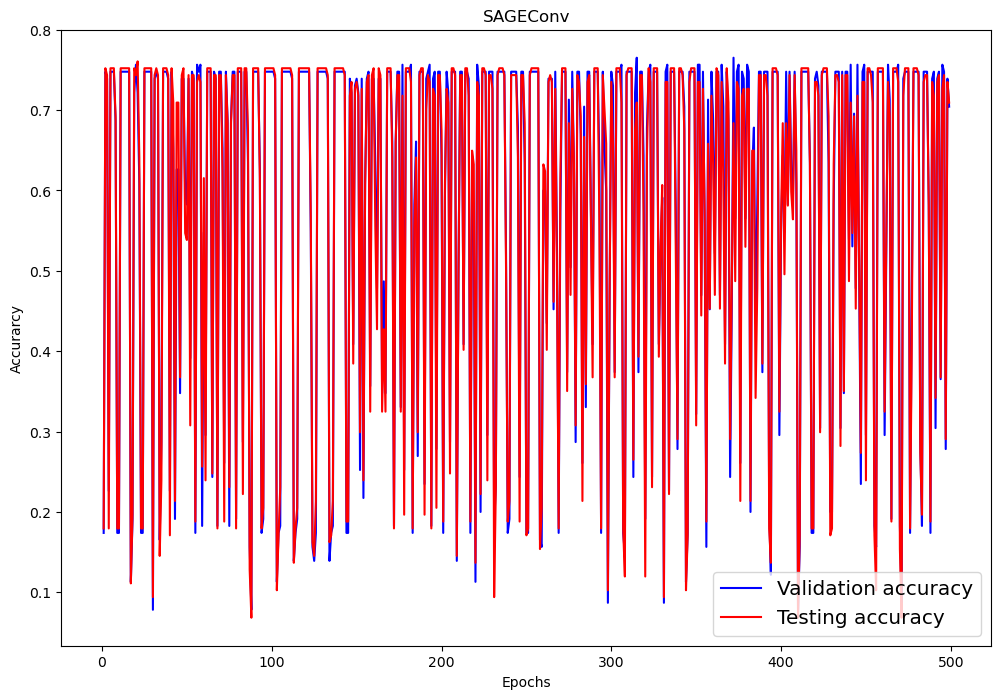

In [105]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('SAGEConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

In [106]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Calculate confusion matrix, F1 score, precision, recall, and ROAUC
mask_val = data.val_mask
mask_test = data.test_mask
model.eval()

out_val = model(data.x, data.edge_index)[mask_val].argmax(dim=1)
out_test = model(data.x, data.edge_index)[mask_test].argmax(dim=1)
y_true_val = data.y[mask_val]
y_true_test = data.y[mask_test]

confusion_matrix_val = confusion_matrix(y_true_val, out_val)
confusion_matrix_test = confusion_matrix(y_true_test, out_test)
f1_score_val = f1_score(y_true_val, out_val, average='weighted')
f1_score_test = f1_score(y_true_test, out_test, average='weighted')
precision_val = precision_score(y_true_val, out_val, average='weighted')
precision_test = precision_score(y_true_test, out_test, average='weighted')
recall_val = recall_score(y_true_val, out_val, average='weighted')
recall_test = recall_score(y_true_test, out_test, average='weighted')

# # ROAUC requires probability scores instead of predicted labels
# out_val_probs = np.max(out_val.softmax(dim=0).detach().cpu().numpy(), axis=1)
# out_test_probs = np.max(out_test.softmax(dim=0).detach().cpu().numpy(), axis=1)
# roauc_val = roc_auc_score(y_true_val.cpu().numpy(), out_val_probs)
# roauc_test = roc_auc_score(y_true_test.cpu().numpy(), out_test_probs)

# Print the results
print("Confusion Matrix (Validation):\n", confusion_matrix_val)
print("Confusion Matrix (Test):\n", confusion_matrix_test)
print("\nF1 Score (Validation):", f1_score_val)
print("F1 Score (Test):", f1_score_test)
print("\nPrecision (Validation):", precision_val)
print("Precision (Test):", precision_test)
print("\nRecall (Validation):", recall_val)
print("Recall (Test):", recall_test)
# print("ROAUC (Validation):", roauc_val)
# print("ROAUC (Test):", roauc_test)


Confusion Matrix (Validation):
 [[78  8  0]
 [ 6  3  0]
 [17  3  0]]
Confusion Matrix (Test):
 [[81  7  0]
 [ 6  2  0]
 [19  2  0]]

F1 Score (Validation): 0.6442707964780687
F1 Score (Test): 0.6424679197332481

Precision (Validation): 0.5942992435889551
Precision (Test): 0.5871780211402853

Recall (Validation): 0.7043478260869566
Recall (Test): 0.7094017094017094


/home/almusawiaf/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/almusawiaf/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
